# basic analysis from https://doi.org/10.1021/acs.jpca.5b10667 (Jim and Kelly MetaD rates paper) 

In [1]:
#libraries needed
import matplotlib.pyplot as plt 
import numpy as np
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.lines as mlines
from scipy.optimize import curve_fit
from scipy.misc import factorial
from scipy.stats import ks_2samp
from scipy import stats

/Users/jpfaendt/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# the data frame is a 2 column list of numbers from one of my MD scripts (units = sec)
# column one is the 'accelerated' time (esacpe time in MD multipled by alpha)
datain=np.genfromtxt('fu.txt')
data=datain[:,1]*1e9
#rint np.size(data)
#data now in "ns for each escape event
min=np.min(data)
max=np.max(data)
bins=10*np.size(data)

#logscale of times
time=np.logspace(np.log10(min),np.log10(max),num=bins)
mu=np.mean(data)

#print time
time_centers = np.r_[0.5 * (time[:-1] + time[1:])]
#print time_centers
#this is because MATLAB works on the bin centers, numpy works on the bin edges


In [4]:
stats.kstest(data,'gamma',args=stats.gamma.fit(data))


KstestResult(statistic=0.073096837534262771, pvalue=0.00036614029697146222)

In [5]:
def analyticalCDF(times,tau):
    return 1-np.exp(-times/tau)
    

In [6]:
print np.std(data)
print stats.sem(data)

124.559790936
4.40660863332


In [7]:
#Make histogram and CDF
hist, bins2=np.histogram(data,bins=time,density=False)
cdf=np.cumsum(hist)*1.0/data.size


In [8]:
#Fit the CDF 
taufit, pcov = curve_fit(analyticalCDF,time_centers, cdf,mu)
print "mu (ns)\t\t" ,mu
print "taufit (ns)\t" ,taufit[0]


mu (ns)		81.73272479
taufit (ns)	57.5940687355


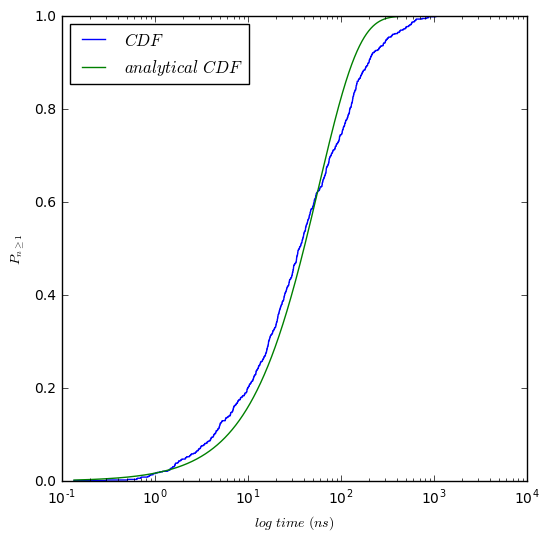

In [9]:
#lets make some plots
%matplotlib inline 
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

axes = fig.add_subplot(111)
axes.plot(bins2[1:bins],cdf,label='$CDF$')
axes.set_xscale('log')
axes.plot(time_centers,analyticalCDF(time_centers,taufit),label='$analytical\ CDF$')
first_legend = plt.legend(loc=0)
axes.set_xlabel('$log\ time\ (ns)$')
axes.set_ylabel('$P_{n\geq1}$')
plt.show()

In [10]:
#generate  random data points from the analytical fit based on taufit
points=1
randdata=np.random.gamma(1,taufit,np.size(data)*points)

#perfrom the KS test to see if the data points from MetaD are statistically
#the same as the data points from the analytical fit
stat,p=ks_2samp(data,randdata)

In [11]:
#data table: 
print "mu:" , np.mean(data)
print "mu_sem:", stats.sem(data)
print "sigma:", np.std(data,ddof=1) 
print "t_m:", np.median(data)
print "tau:", taufit
print "mu_sigma_ratio:", np.mean(data)/np.std(data,ddof=1)
print "log2mu_median_ratio:", np.log(2)*np.mean(data)/np.median(data)
print "tau_mu_ratio:", taufit/np.mean(data)
print "p-value:" , p
print "ks-stat:" , stat
print "events recorded:" ,  np.size(data)

mu: 81.73272479
mu_sem: 4.40660863332
sigma: 124.637713866
t_m: 35.5623
tau: [ 57.59406874]
mu_sigma_ratio: 0.65576238728
log2mu_median_ratio: 1.59305803471
tau_mu_ratio: [ 0.70466351]
p-value: 0.000213515608967
ks-stat: 0.10625
events recorded: 800


### Random sampling on data set - I think this will bootstrap the data and then do the KS analysis

In [12]:
##random sampling on data set
def sampling(data,num_iters,sampsize):
   # if sampsize > 100 
   #     sampsize = 100 
        
        
    means=np.array([0.0])
    pvals=np.array([0.0])
    points=1e4 #number of sampling points for p-val
    alpha=0.05
    reject=0.0
    #for i in range((num_iters)):
    while np.size(means) <= num_iters: 
        smalldata=np.random.choice(data,sampsize,replace=True)
        #hist / CDF fit / etc
        min=np.min(smalldata)
        max=np.max(smalldata)
        bins=10*np.size(smalldata)
        time=np.logspace(np.log10(min),np.log10(max),num=bins)
        mu=np.mean(smalldata)
        time_centers = np.r_[0.5 * (time[:-1] + time[1:])]
        hist, bins2=np.histogram(smalldata,bins=time,density=False)
        cdf=np.cumsum(hist)*1.0/smalldata.size
        taufit, pcov = curve_fit(analyticalCDF,time_centers, cdf,mu)
        #analysis 
        randdata=np.random.gamma(1,taufit,np.size(data)*points)
        stat,p=ks_2samp(smalldata,randdata)
        if p > alpha:
            means[means.size-1]=mu
            pvals[pvals.size-1]=p
            #debugprint p, mu
            means.resize(means.size+1)
            pvals.resize(pvals.size+1)
        if p < alpha:
            reject=reject+1
    #this is just book keeping to remove the last 0 element
    means=means[:(means.size-1)]
    pvals=pvals[:(pvals.size-1)]
    return means, pvals, reject

In [23]:
#run the sampling
#want to sample all rx*.txt , store in a dictionary (show me how to print the dictionary)

# Easiest way to to do what you want is this (assuming you'll always be doing it in an ipython notebook):
rx_filenames = !ls rx*.txt
rx_filenames = !ls rxdata_600K_100K.txt rxdata_525K_100K.txt rxdata_450_3.txt rxdata_375_1.txt rxdata_300_100K.txt NEW_525K_unbias.dat.dat NEW_600K_unbias.dat.dat NEW_900K_unbias.dat.dat NEW_1200K_unbias.dat.dat rxdata_300_200K.txt rxdata_300_100K.txt rxdata_300_20K.txt final_20K/rxdata_300.txt rxdata_300_5K.txt rxdata_300_1K.txt rxdata_300_.5K.txt rxdata_300_.05K.txt rxdata_300_.025K.txt rxdata_300_.005K.txt
rx_filenames = !ls rxdata_450_2.txt
# If you want to be able to do something similar in a .py file then use os.listdir():
 #import os
#rx_filenames = [x for x in os.listdir('.') if x[-4]: == '.txt']
                             
results = {}   # Initialize your dictionary of results 


for name in rx_filenames:
    datain=np.genfromtxt(name)
    data=datain[:,1]*1e9
    niter=1000 # how many runs
    size=.5 # how big of a sample size to take as a percentage of the total set
    means,pvals,reject=sampling(data,niter,np.int(size*np.size(data)))
    #results[name] = [np.mean(means),stats.sem(means),np.std(means),np.mean(pvals),reject,means,pvals]
    results[name] = [np.mean(means),stats.sem(means),np.std(means),np.mean(pvals),reject]
     
# to get the results for a specific filename just use:
#results[filename]
# it will return a list where index 0 is mu, 1 is sem, 2 is avg-p

# to print the whole dictionary type
results
# this will only work if you don't have any other commands later in the cell that return output.  If you want
# it to print before other stuff you'll have to use print (but it won't print as a table if you use "print" unless
# you loop through each item in results with your print statement

{'rxdata_450_2.txt': [4.0168908747228267,
  0.015442182297623645,
  0.4880804576285841,
  0.58681435185115038,
  9.0]}

In [ ]:
#analysis of sampling
%matplotlib inline 
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.2, hspace=0.2)
xr=np.arange(0,means.size)
axes = fig.add_subplot(211)
axes.plot(xr,means,label='sample means')
axes.set_xlabel('iter')
axes.set_ylabel('sample mean')
axes = fig.add_subplot(212)
axes.plot(xr,pvals,label='sample ps')
axes.set_xlabel('iter')
axes.set_ylabel('sample p')
plt.show()